# Model including W POS data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Input, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import concatenate

Using TensorFlow backend.


In [6]:
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from utils import Reshape

## Parameters

In [7]:
PREFILTER = True
PREFILTER_THRESHOLD = 0.2 # Data excluded if Brand variance greather than 0.2M or less than -0.2M

WINDOW_SIZE = 13 # Timeseries window size in months

UNDERSAMPLE = True
UNDERSAMPLE_RATIO = 0.7 #  Amount of data with no comment =  Amount of data with comment / UNDERSAMPLE_RATIO
EXTRA_TEST_DATA = 100 # Amount of data thrown out when undersampling to include in the test set

OVERSAMPLE = True

AUGMENT_DATA = True

DATA = ["Variance", "POS"] # "Variance", "All", 
MODEL = "LSTM"    # 


## Loading Data

commentaries_to_pickle.py to save commentary spreedsheet to pickle

In [1509]:
from helper_save_load import load_from_pickle

df_c = load_from_pickle("data/Labeled_comments2.pkl")
# df_c.drop(columns=['Safeway', 'Baseline'], inplace=True) # If Labeled_comments.pkl

In [1510]:
# These brands are in df_c but do not appear in the variance dataframe df_v
ignored_brands = ["IGNORE",
"57-CAMAY BAR SOAP Brand",
"71-LBP SH/CD Roll-up Brand",
"72-LBP SHOWER Roll-up Brand"]

df_c = df_c[~df_c["Brand_1"].isin(ignored_brands)]

In [1511]:
df_c.insert(16, "NoComm", df_c["Commentaries"].isnull())
df_c.insert(16, "Other", (df_c[['Promo', 'Phasing', 'SP&D', 'POS']].sum(axis=1) == 0) & ~df_c['NoComm'])
df_c["Month"] = pd.to_datetime(df_c["Month"]).dt.strftime("%b_%Y")

In [1502]:
label_cols = ['Promo', 'Phasing', 'SP&D', 'POS', 'Other', 'NoComm']

territory_label_cols = df_c.columns[18:31].to_list()
territory_labels = df_c[territory_label_cols]

In [12]:
df_a, df_f, df_v = load_from_pickle("data/dataframes_Dollars.pickle")
del df_a, df_f

In [13]:
territories = [territory for territory, values in df_v.groupby(['Territory']).groups.items()]

In [14]:
pos_with_brands = load_from_pickle('data/pos_with_brands.pickle')
pos_with_brands['UnitPrice'] = pos_with_brands['TotalSales'] / pos_with_brands['TotalQty']

pos_with_brands.replace([np.inf, -np.inf], 0, inplace=True) # Replace ~0 / 0 with zero

In [929]:
inv_with_brands = load_from_pickle('data/inventory_with_brands.pickle')


## Pre-Filtering Data
Including data if variance is greater than the 0.2M threshold

In [1512]:
test = df_c[(~df_c["Num"].duplicated())]
len(test[test["NoComm"] == 1]) / len(test) # Fraction of number of brand-month pairs with no commentaries

0.7415946205571565

In [1513]:
len(test[test["NoComm"] == 1])

772

In [1514]:
if PREFILTER:
    df_c = df_c[(df_c["Variance"] >= PREFILTER_THRESHOLD) | (df_c["Variance"] <= -PREFILTER_THRESHOLD)]

In [1515]:
test = df_c[(~df_c["Num"].duplicated())]
len(test[test["NoComm"] == 1]) / len(test) #Fraction of number of brand-month pairs with no commentaries after filtering


0.12237762237762238

528

In [1532]:
df_c[df_c["Num"] == 225]["Commentaries"]

1136    MP oversell $0.5M vs SOP5, (MBR oversell +$0.8...
1137    Balance driven by IMP at OOH MD Build cycling ...
Name: Commentaries, dtype: object

In [ ]:
df_c[df_c[territory_label_cols].sum(1) ==0][["Num"] + territory_label_cols]

In [1518]:
len(test) - 35

251

In [1516]:
len(test[test["NoComm"] == 1])

35

## Removing multiclass labels

Rows with multiple positive class labels are changed to a single label according to the importance of the class

In [18]:
CLASS_PRIORITY = ["Promo", "SP&D", "Phasing", "POS"] # Most important class to predict to least

print('Number of multiclass labels before:', sum(df_c[label_cols].sum(axis=1) > 1))
      
for idx, row in df_c[df_c[label_cols[:4]].sum(axis=1) > 1][label_cols[:4]].iterrows():
    positive_label_idx = min([CLASS_PRIORITY.index(c) for c in row[row > 0].index])
    negative_labels = CLASS_PRIORITY[:]
    negative_labels.pop(positive_label_idx) # List of columns to set to zero
    df_c.loc[idx, negative_labels] = 0

print('Number of multiclass labels after:', sum(df_c[label_cols].sum(axis=1) > 1))

Number of multiclass labels before: 38
Number of multiclass labels after: 0


## Reshaping Data

In [19]:
TR_BR_grouped = df_v.groupby(["Territory", "Brand"]).sum()

Summing variances for all associated subterritories for each labeled territory and placing them in a dictionary

In [21]:
variance_dict = {}
for territory, subterritories in territory_dict.items():
    summed_variance = pd.DataFrame()
    for subterritory in subterritories:
        summed_variance = summed_variance.add(TR_BR_grouped.loc[subterritory], fill_value=0)
        
    variance_dict[territory] = summed_variance

In [ ]:
for t, v in variance_dict.items():
    print(t, v.shape)

In [23]:
territory_label_cols = ['WM']
# territory_label_cols = df_c.columns[18:31]

Variance time series (all months) for labeled territories. Zeros if no data for brand-territory.

In [1535]:
# Brand x territory x months
# Row of zeros if empty
brands = df_v["Brand"].unique()
months = df_v.columns[8:]

all_brands_variance = []

for brand in brands:
    temp = []
    for territory in territory_label_cols:
        if brand in variance_dict[territory].index:
            temp.append(variance_dict[territory].loc[brand].values)
        else:
            temp.append(np.zeros(len(months)))
    all_brands_variance.append(temp)
    
all_brands_variance = np.array(all_brands_variance)
all_brands_variance.shape

(136, 13, 34)

For each unique brand-month pair (known to be unique by the "Num" column) we take a 12 month window of data for each labeled territory. Thus the output should have #unique brand-month pairs * 13 territories rows.

The labels are generated as well. The default label for when a territory is not involved is [0, 0, 0, 0, 0]

In [1536]:
# Generates full list of WINDOW_SIZE length timeseries and corresponding class labels
# for every *unique* brand-month pair in commentary spreadsheet

labels = []
BR_TR_timeseries_windows = []
previous_commentary_num = -1
brand_month_labels = None

for idx, row in df_c.iterrows():
    brand_idx = np.where(brands==row["Brand_1"])[0][0]
    month_idx = np.where(months==row["Month"])[0][0]
    t_idx = np.flatnonzero(row.fillna(0)[territory_label_cols]) # Index of territory_label for this row
    
    # Due to splitting of commentaries we have repeated brand-month pairs in data
    # Keeping track of which commentary so we don't repeat its timeseries
    current_commentary_num = row["Num"] 
    
    if current_commentary_num != previous_commentary_num:
        # First instance of brand-month pair
        labels.append(brand_month_labels)
        
        brand_month_labels = np.zeros((len(territory_label_cols), len(label_cols)), dtype=int)
        brand_month_labels[:, 5] = 1 # Default NoComm
        
        if t_idx.size > 0:
            brand_month_labels[t_idx[0]] = row[label_cols].fillna(0).values
        
        for i in range(len(territory_label_cols)):

            # Appending 12 month windows per brand per territory as input
            if month_idx - WINDOW_SIZE < 0:
                padding = np.zeros(WINDOW_SIZE - month_idx -1) # pad with zeros if less than 12
                window = np.concatenate((padding, all_brands_variance[brand_idx, i, :month_idx+1]))
            else:
                window = all_brands_variance[brand_idx, i, (month_idx-WINDOW_SIZE+1):month_idx+1]
            BR_TR_timeseries_windows.append(window)
    else:
        # Repeated instances of brand-month pair
        if t_idx.size > 0:
            brand_month_labels[t_idx[0]] = row[label_cols].fillna(0).values

    previous_commentary_num = current_commentary_num
    
labels.append(brand_month_labels) # Append the final labels
BR_TR_timeseries_windows = np.array(BR_TR_timeseries_windows)
BR_TR_labels = np.vstack(labels[1:])
BR_TR_timeseries_windows = (BR_TR_timeseries_windows -BR_TR_timeseries_windows.mean()) / BR_TR_timeseries_windows.std()

print("X data shape:", BR_TR_timeseries_windows.shape) # 286 brand-month pairs * 13 territories, 12 months
print("y data shape:", BR_TR_labels.shape)             # 286 brand-month pairs * 13 territories, 5 labels

X data shape: (3718, 13)
y data shape: (3718, 6)


In [1537]:
X = BR_TR_timeseries_windows[:]
y = BR_TR_labels[:]

In [321]:
df_c.Num.nunique() # Number of unique brand-month pairs i.e. number of unsplit commentaries 

286

In [322]:
sum(BR_TR_labels) # Class memberships (Promo, Phasing, SP&D, POS, Other, NoComm)

array([ 30,  11,   4,  19,   3, 219])

In [ ]:
plt.bar(label_cols, sum(y_r), color='b')
plt.title("Class Memberships After Oversampling")
# plt.savefig('Oversampling.png')

## POS timeseries windows (monthly)

Just using TotalSales column for now. should be adjusted to either include both TotalSales and TotalQty. Or unitprice.

In [323]:
monthly_pos = pos_with_brands.groupby([pos_with_brands["POSDate"].dt.to_period('M'), "Brand"]).\
               agg({"TotalSales":"sum", "TotalQty":"sum", "UnitPrice":"sum"}).reset_index()
monthly_pos['POSDate'] = pd.to_datetime(monthly_pos['POSDate'].astype(str)).dt.strftime('%b_%Y')

In [324]:
unique_brand_month_pairs = df_c[~df_c['Num'].duplicated()][['Num', 'Brand_1', 'Month']]

months = monthly_pos['POSDate'].unique().tolist()
monthly_pos_pivot = pd.pivot_table(monthly_pos, index='Brand', columns='POSDate', values='UnitPrice') 
monthly_pos_pivot = monthly_pos_pivot.reindex(months, axis=1)
monthly_pos_pivot.fillna(0, inplace=True)
brands = monthly_pos_pivot.index.tolist()
monthly_pos_data = monthly_pos_pivot.values

<function list.index>

In [325]:
monthly_pos_windows = []
for i, row in unique_brand_month_pairs.iterrows():
    month_idx = months.index(row['Month'])
    brand_idx = brands.index(row['Brand_1'])
    
    if month_idx - WINDOW_SIZE < 0:
        padding = np.zeros(WINDOW_SIZE - month_idx - 1) # pad with zeros if less than WINDOW_SIZE
        window = np.concatenate((padding, monthly_pos_data[brand_idx, :month_idx+1]))
    else:
        window = monthly_pos_data[brand_idx, (month_idx-WINDOW_SIZE+1):month_idx+1]
        
    assert(len(window) == WINDOW_SIZE)
    monthly_pos_windows.append(window)
    
monthly_pos_windows = np.array(monthly_pos_windows)

In [827]:
monthly_pos_windows = (monthly_pos_windows - monthly_pos_windows.mean()) / monthly_pos_windows.std()

## POS timeseries windows (weekly)

In [175]:
weekly_pos = pos_with_brands.groupby([pos_with_brands["POSDate"].dt.to_period('W'), "Brand"]).\
               agg({"TotalSales":"sum", "TotalQty":"sum"}).reset_index()
weekly_pos_pivot = pd.pivot_table(weekly_pos, index='Brand', columns='POSDate', values='TotalSales')

In [ ]:
for brand in brands:
    
# Label for apr2017 add weeks up to and including weeks in apr2017
    

## Inventory monthly windows

In [942]:
agg_dict = {}

#Are these the right columns to sum/avg?
cols_to_sum = inv_with_brands.columns[2:8].tolist()
cols_to_avg = inv_with_brands.columns[8:-1].to_list()
    
for col in cols_to_sum:
    agg_dict[col] = np.sum

for col in cols_to_avg:
    agg_dict[col] = np.mean

In [946]:
# Should have agg_dict where some columns are summed and some are averaged
monthly_inv = inv_with_brands.groupby([inv_with_brands["POSDate"].dt.to_period("M"), "Brand"]).agg(
                                            agg_dict).reset_index()
monthly_inv['POSDate'] = pd.to_datetime(monthly_inv['POSDate'].astype(str)).dt.strftime('%b_%Y')

In [947]:
months = monthly_inv['POSDate'].unique().tolist()

monthly_inv_pivot = pd.pivot_table(monthly_inv, index='Brand', columns='POSDate', values='CurrStrOnHandQty')
monthly_inv_pivot = monthly_inv_pivot.reindex(months, axis=1)
monthly_inv_pivot.fillna(0, inplace=True)

brands = monthly_inv_pivot.index.tolist()
monthly_inv_data = monthly_inv_pivot.values

In [949]:
monthly_inv_windows = []
for i, row in unique_brand_month_pairs.iterrows():
    month_idx = months.index(row['Month'])
    brand_idx = brands.index(row['Brand_1'])
    
    if month_idx - WINDOW_SIZE < 0:
        padding = np.zeros(WINDOW_SIZE - month_idx - 1) # pad with zeros if less than WINDOW_SIZE
        window = np.concatenate((padding, monthly_inv_data[brand_idx, :month_idx+1]))
    else:
        window = monthly_inv_data[brand_idx, (month_idx-WINDOW_SIZE+1):month_idx+1]
        
    assert(len(window) == WINDOW_SIZE)
    monthly_inv_windows.append(window)
    
monthly_inv_windows = np.array(monthly_inv_windows)

In [1060]:
monthly_inv_windows = (monthly_inv_windows - monthly_inv_windows.mean()) / monthly_inv_windows.std()

## Augmenting data with noise

In [148]:
# Adding noise to variance data to generate more samples to learn from

## Making a test set

In [987]:
from sklearn.model_selection import train_test_split

X = np.concatenate((BR_TR_timeseries_windows, monthly_pos_windows), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Undersampling

In [298]:
if UNDERSAMPLE:
    
    print("Length of data:",len(X_train))
    print("No Comment:", sum(y_train[:, 5] == 1))
    print("With Comment:", sum(y_train[:, 5] == 0))
    
    nonzero_data = np.where(X_train.sum(axis=1) != 0)
    X_train = X_train[nonzero_data]
    y_train = y_train[nonzero_data]
    
    no_comment_idx = np.where(y_train[:, 5] == 1)[0]
    with_comment_idx = np.where(y_train[:, 5] == 0)[0]

    no_comment_count = sum(y_train[:, 5] == 1)   
    with_comment_count = sum(y_train[:, 5] == 0)
    
    np.random.shuffle(no_comment_idx)
    undersample_no_comment_idx = no_comment_idx[:int(with_comment_count/UNDERSAMPLE_RATIO)]
    excluded_data_idx = no_comment_idx[int(with_comment_count/UNDERSAMPLE_RATIO):]
    
    
    undersample_idx = np.concatenate((undersample_no_comment_idx, with_comment_idx))
    undersample_idx.sort(kind='mergesort') # Preserving order of data
    
    excluded_data = X_train[excluded_data_idx]
    excluded_labels = y_train[excluded_data_idx]
    
    X_train = X_train[undersample_idx]
    y_train = y_train[undersample_idx]

Length of data: 228
No Comment: 178
With Comment: 50


In [299]:
print("Length of data:", len(X_train))
print("No Comment:", sum(y_train[:, 5] == 1))
print("With Comment:", sum(y_train[:, 5] == 0))

Length of data: 150
No Comment: 100
With Comment: 50


In [80]:
# Time series with zero data Before and after
sum(BR_TR_timeseries_windows.sum(axis=1)==0), sum(X.sum(axis=1) == 0) 

(3, 1)

## Oversampling small classes

In [217]:
from imblearn.over_sampling import RandomOverSampler

# Naive oversampling
if OVERSAMPLE:
    print("Class memberships before:", sum(y_train))
    ros = RandomOverSampler()
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    print("Class memberships after:", sum(y_resampled))

Class memberships before: [ 24   9   4  18   3 170]
Class memberships after: [170 170 170 170 170 170]


### Split the data back into var and pos

In [219]:
varX_train = X_resampled[:, :WINDOW_SIZE]
posX_train = X_resampled[:, WINDOW_SIZE:]

varX_test = X_test[:, :WINDOW_SIZE]
posX_test = X_test[:, WINDOW_SIZE:]

## Baseline (RandomForest)

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix

In [308]:
def plot_feature_importances(model, ax):
    n_features = WINDOW_SIZE*2
    ax.barh(range(n_features), model.feature_importances_, align='center')
#     ax.yticks(np.arange(n_features))
#     ax.setxlabel("Feature importance")
#     ax.ylabel("Feature")
#     ax.ylim(-1, n_features)

<BarContainer object of 26 artists>

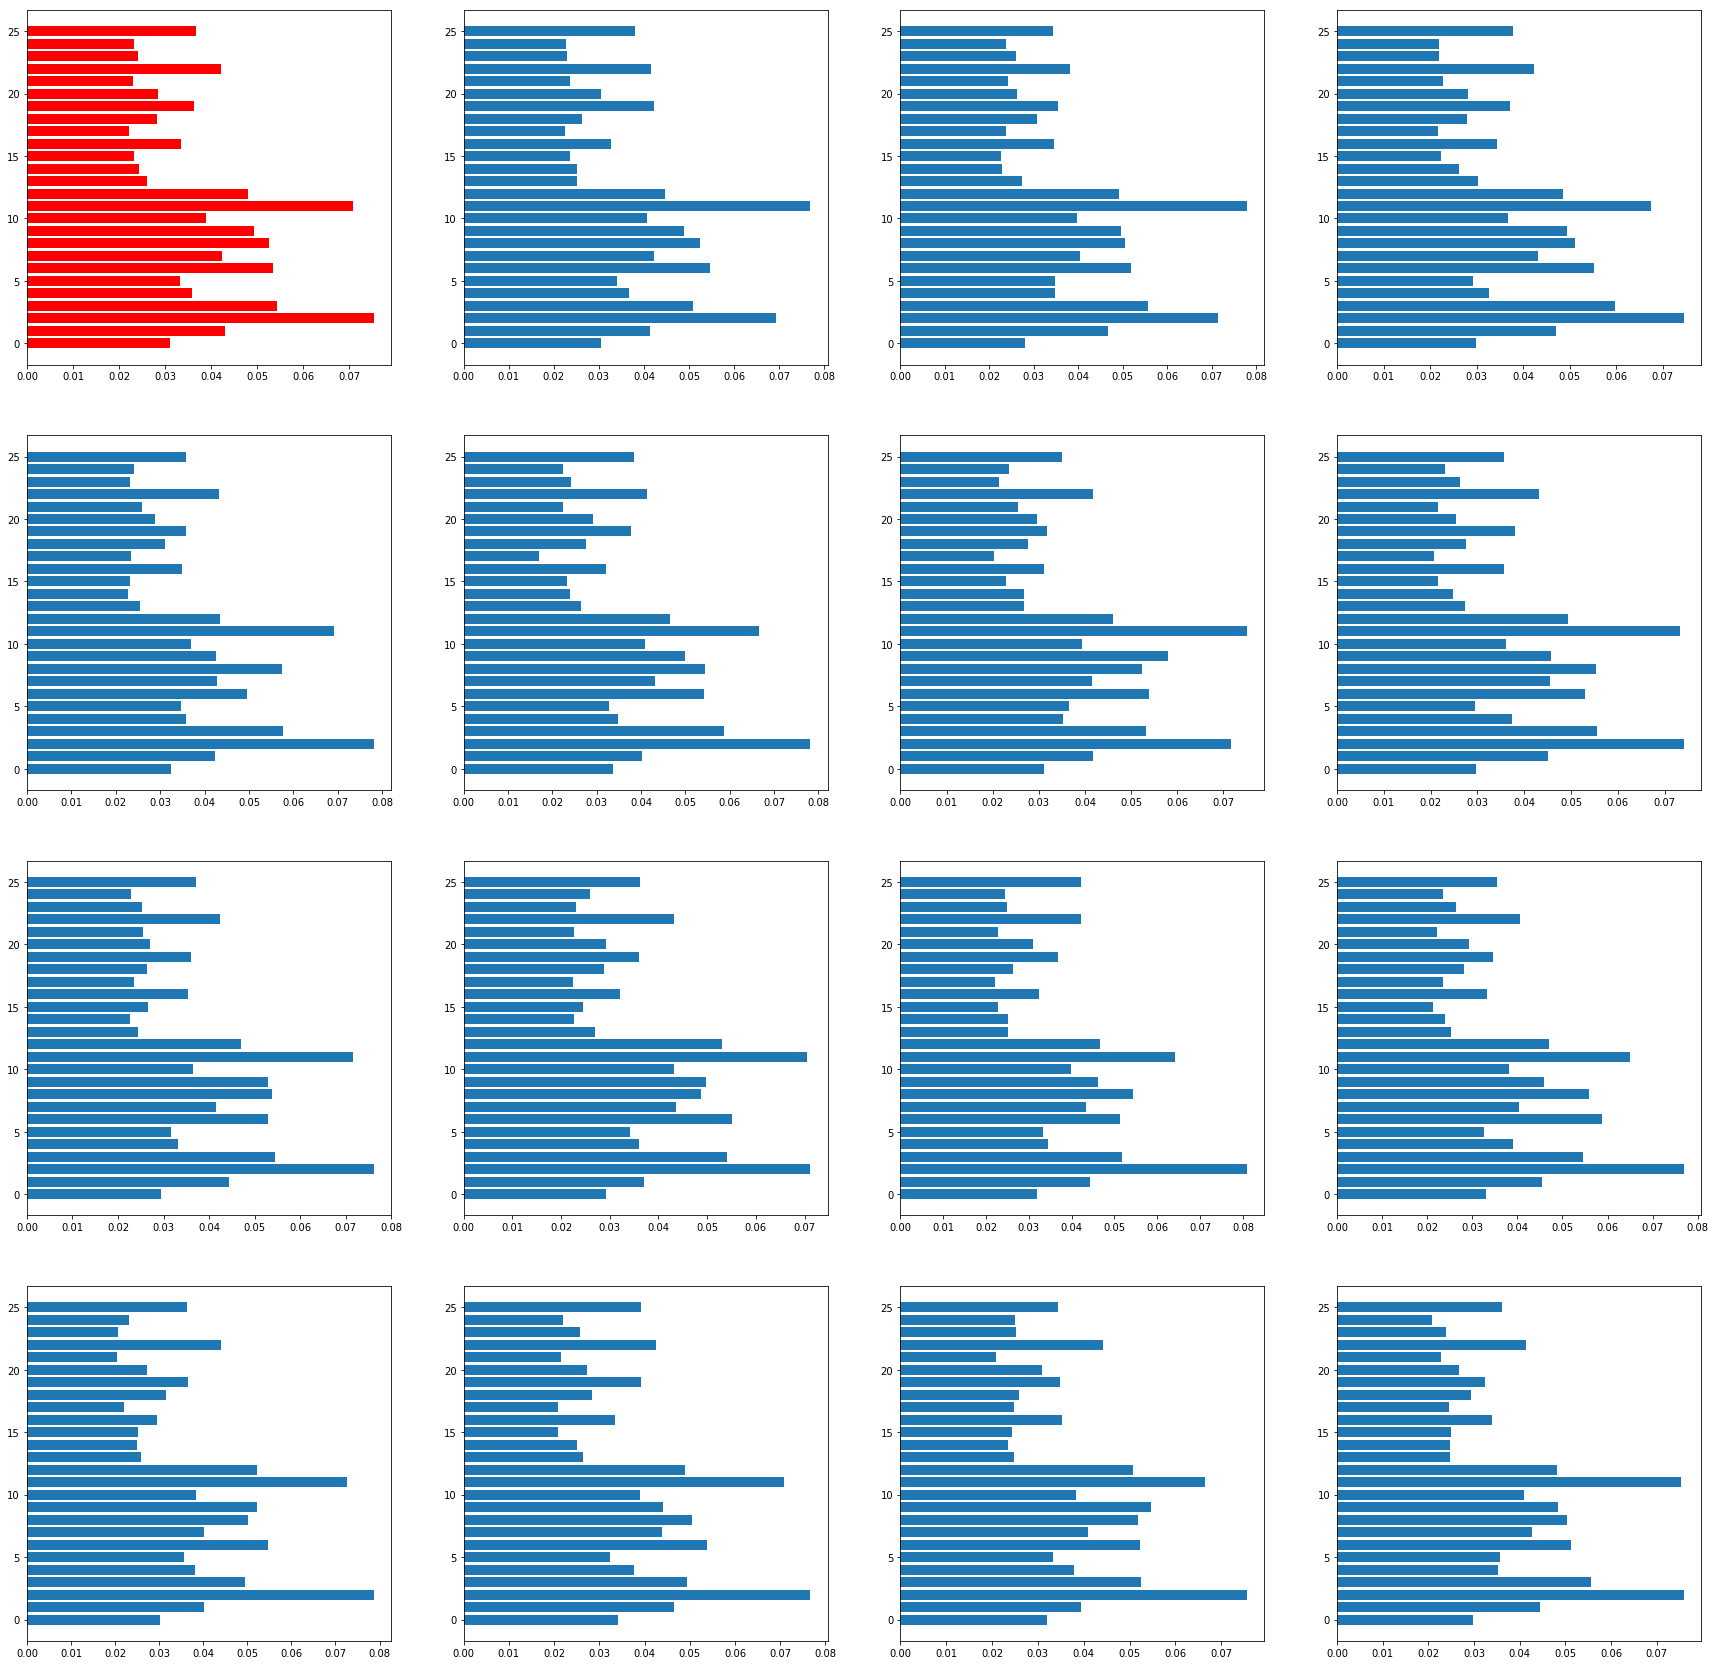

In [309]:
fig, axs = plt.subplots(4, 4, figsize=(30,30))

axs = axs.ravel()

average_feature_importance = np.zeros(WINDOW_SIZE*2)
for i in range(1, 16):
    rf = RandomForestClassifier(200)
    rf.fit(X_resampled, np.argmax(y_resampled, 1))
    average_feature_importance += rf.feature_importances_
    plot_feature_importances(rf, axs[i])
average_feature_importance /= 15
axs[0].barh(range(WINDOW_SIZE*2), average_feature_importance, align='center', color='r')

## Multiclass Model

In [1059]:
def create_model(h1=100, h2=60, d1=0.2, rd1=0.2, d2=0.2, rd2=0.2):
    var_input = Input(shape=(WINDOW_SIZE, 1))
    var_lstm = LSTM(h1, dropout=d1, recurrent_dropout=rd1)
    var_output = var_lstm(var_input)

    pos_input = Input(shape=(WINDOW_SIZE, 1))
    pos_lstm = LSTM(h2, dropout=d2, recurrent_dropout=rd2)
    pos_output = pos_lstm(pos_input)

    merged = concatenate([var_output, pos_output])
    classifier = Dense(6, activation='softmax')
    model_output = classifier(merged)

    model = Model([var_input, pos_input], model_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    
    return model

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from utils import SplitAndReshape


model = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', SplitAndReshape()),
    ('clf', KerasClassifier(create_model, verbose=0))
])

# Grid search parameters
hidden_size1 = [40, 60, 80]
hidden_size2 = [100, 120,150]
epochs = [60, 80, 100]
batch_size = [8, 16, 32]
dropout1 = [0.2, 0.5]
dropout2 = [0.2, 0.5]
r_dropout1 = [0.2, 0.5]
r_dropout2 = [0.2, 0.5]

scoring={'f1_macro':'f1_macro', 
         'f1_micro':'f1_micro', 
         'gms_macro':make_scorer(geometric_mean_score, average='macro'), 
         'gms_micro':make_scorer(geometric_mean_score, average='micro')}

param_grid = {'clf__h1':hidden_size1,
              'clf__h2':hidden_size2,
              'clf__batch_size':batch_size,
              'clf__epochs':epochs,
              'clf__d1':dropout1,
              'clf__rd1':r_dropout1,
              'clf__d2':dropout2,
              'clf__rd2':r_dropout2}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, refit='f1_macro')

grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))

In [ ]:
grid_search.best_params_

In [841]:
scores = grid_search.cv_results_['mean_test_f1_macro']
# f1_micro = grid_search.cv_results_['mean_test_f1_micro']
# f1_macro = grid_search.cv_results_['mean_test_f1_macro']
params = grid_search.cv_results_['params']

for score, param in zip(scores, params):
    if score > 0.21:
        print(score, param)

0.2168214773545579 {'clf__batch_size': 8, 'clf__d1': 0.2, 'clf__d2': 0.5, 'clf__epochs': 60, 'clf__h1': 100, 'clf__h2': 100}
0.21234271145257194 {'clf__batch_size': 8, 'clf__d1': 0.2, 'clf__d2': 0.5, 'clf__epochs': 60, 'clf__h1': 120, 'clf__h2': 120}
0.22235151171898163 {'clf__batch_size': 16, 'clf__d1': 0.2, 'clf__d2': 0.5, 'clf__epochs': 60, 'clf__h1': 100, 'clf__h2': 60}
0.2105936806001993 {'clf__batch_size': 16, 'clf__d1': 0.2, 'clf__d2': 0.5, 'clf__epochs': 60, 'clf__h1': 120, 'clf__h2': 100}
0.2186019637902168 {'clf__batch_size': 16, 'clf__d1': 0.2, 'clf__d2': 0.5, 'clf__epochs': 80, 'clf__h1': 120, 'clf__h2': 120}
0.22095777090445134 {'clf__batch_size': 32, 'clf__d1': 0.2, 'clf__d2': 0.5, 'clf__epochs': 80, 'clf__h1': 120, 'clf__h2': 100}


In [ ]:
model = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', SplitAndReshape()),
    ('clf', KerasClassifier(create_model, epochs=60, batch_size=16, verbose=0))
])

results = evaluate_model(model)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

In [784]:
def color_dataframe(row):
    color = to_hex(plt.cm.RdBu(row.weight* 10 +0.5))
    return pd.Series('background-color: %s' % color, row.index)

def permutation_importance(estimator, runs=10):
    
    weights = np.zeros(26)
    std = np.zeros(26)
    for _ in range(runs):
        model = estimator
        model.fit(X_train, np.argmax(y_train,1))

        perm = PermutationImportance(model, scoring='f1_macro').fit(X_test, np.argmax(y_test, 1))
        df = eli5.format_as_dataframe(eli5.explain_weights(perm, top=26, feature_names=[str(i) for i in range(26)]))
        df['feature'] = pd.to_numeric(df['feature'])
        df.sort_values(by='feature', inplace=True)
        
        weights += df['weight'].values
        std += df['std'].values
        
    weights /= runs
    std /= runs
    features = ['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)]

    df_perm_importance = pd.DataFrame(data=np.vstack((weights, std)).T, columns=['weight', 'std'])
    df_perm_importance.insert(0, 'features', features)
    df_perm_importance.sort_values('weight', ascending=False, inplace=True)
    df_perm_importance.reset_index(drop=True, inplace=True)
    
    return df_perm_importance.style.apply(color_dataframe, axis=1)
    

In [ ]:
model = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', SplitAndReshape()),
    ('clf', KerasClassifier(create_model, epochs=60, batch_size=16, verbose=0))
])
permutation_importance(model)

In [1026]:
def evaluate_model(estimator, runs=10):
    
    metrics = ['precision_macro', 'precision_micro', 'recall_macro', 'recall_micro',
              'f1_macro', 'f1_micro', 'gms_macro', 'gms_micro']
    results = {m:[] for m in metrics}

    for _ in range(runs):
        model = estimator
        model.fit(X_train, np.argmax(y_train, 1))
        y_pred = model.predict(X_test)

        results['precision_macro'].append(precision_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['precision_micro'].append(precision_score(np.argmax(y_test,1), y_pred, average='micro')) 
        results['recall_macro'].append(recall_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['recall_micro'].append(recall_score(np.argmax(y_test,1), y_pred, average='micro'))
        results['f1_macro'].append(f1_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['f1_micro'].append(f1_score(np.argmax(y_test,1), y_pred, average='micro'))
        results['gms_macro'].append(geometric_mean_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['gms_micro'].append(geometric_mean_score(np.argmax(y_test,1), y_pred, average='micro'))
    
    return results

In [297]:
def var_model(hidden_size=100, dropout=0.2, recurrent_dropout=0.2):
    model = Sequential()
    model.add(LSTM(hidden_size, input_shape=(WINDOW_SIZE, 1),
                  dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(6, activation='softmax')) 
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam')
    return model

In [95]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_model(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('model accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Single LSTM model

In [307]:
def create_model():
    
    var_input = Input(shape=(WINDOW_SIZE, 2))
    var_lstm = LSTM(100, dropout=0.5, recurrent_dropout=0.5)
    var_output = var_lstm(var_input)

#     pos_input = Input(shape=(WINDOW_SIZE, 1))
#     pos_lstm = LSTM(50, dropout=0.5, recurrent_dropout=0.5)
#     pos_output = pos_lstm(pos_input)
# 
#     merged = concatenate([var_output, pos_output])
    classifier = Dense(6, activation='softmax')
    model_output = classifier(var_output)

    model = Model(var_input, model_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    
    return model

In [313]:
X_train.shape

(228, 26)

In [314]:
# X = np.concatenate((BR_TR_timeseries_windows, monthly_pos_windows), axis=1)

X_train = X_train.reshape(((X_train.shape[0], WINDOW_SIZE, 2)), order='F')
X_test = X_test.reshape(((X_test.shape[0], WINDOW_SIZE, 2)), order='F')

In [316]:
model = create_model()

model.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=8)

Train on 182 samples, validate on 46 samples
Epoch 1/15
182/182 [==============================] - 6s 35ms/step - loss: 1.6206 - val_loss: 1.5612
Epoch 2/15
182/182 [==============================] - 1s 8ms/step - loss: 1.1404 - val_loss: 1.2053
Epoch 3/15
182/182 [==============================] - 1s 7ms/step - loss: 0.9283 - val_loss: 1.1383
Epoch 4/15
182/182 [==============================] - 1s 4ms/step - loss: 0.8641 - val_loss: 1.0825
Epoch 5/15
182/182 [==============================] - 1s 4ms/step - loss: 0.8856 - val_loss: 1.0551
Epoch 6/15
182/182 [==============================] - 1s 6ms/step - loss: 0.8537 - val_loss: 1.0439
Epoch 7/15
182/182 [==============================] - 1s 6ms/step - loss: 0.8426 - val_loss: 1.0481
Epoch 8/15
182/182 [==============================] - 1s 5ms/step - loss: 0.8319 - val_loss: 1.0534
Epoch 9/15
182/182 [==============================] - 1s 6ms/step - loss: 0.8032 - val_loss: 1.0477
Epoch 10/15
182/182 [==============================] -

In [317]:
np.argmax(model.predict(X_test), 1)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [286]:

pre = []
rec = []
fs = []
gms = []


for tr, te in KFold(n_splits=5, shuffle=True).split(X, y):
    for _ in range(1000):
        predictions = np.random.randint(6, size=len(y[te]))

        pre.append(precision_score(np.argmax(y[te], 1), predictions, average='weighted'))
        rec.append(recall_score(np.argmax(y[te], 1), predictions, average='weighted'))
        fs.append(f1_score(np.argmax(y[te], 1), predictions, average='weighted'))
        gms.append(geometric_mean_score(np.argmax(y[te], 1), predictions, average='weighted'))

In [287]:
print(np.mean(pre), np.mean(rec), np.mean(fs), np.mean(gms))

0.608516251080144 0.1682697519661222 0.2335264089546724 0.3698288932185513


In [269]:
print(classification_report_imbalanced(np.argmax(y_test, 1), predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.17      0.25      0.91      0.20      0.48      0.21         4
          1       0.00      0.00      0.88      0.00      0.00      0.00         1
          2       0.00      0.00      0.76      0.00      0.00      0.00         0
          3       0.20      0.67      0.85      0.31      0.75      0.56         3
          4       0.00      0.00      0.81      0.00      0.00      0.00         0
          5       1.00      0.20      1.00      0.33      0.45      0.18        50

avg / total       0.88      0.22      0.98      0.32      0.46      0.20        58



## Random Forest

In [ ]:
# Should try with multivariate timeseries

In [1054]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier())
])

# Grid search parameters
n_estimators = [10, 50, 100, 150, 200]
max_depth = [3, 5, 7, 9, 11, 13, 15, None]

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__n_estimators':n_estimators, 'clf__max_depth':max_depth}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))

In [1055]:
# Changes everytime
grid_search.best_params_

{'clf__max_depth': 15, 'clf__n_estimators': 10}

In [1053]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier(100, max_depth=5))
])

results = evaluate_model(model, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.184
precision_micro 0.602
recall_macro 0.191
recall_micro 0.602
f1_macro 0.172
f1_micro 0.602
gms_macro 0.39
gms_micro 0.736


In [1170]:
feature_importance = np.zeros(26)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(100, max_depth=7))
    ])
    model.fit(X, np.argmax(y, 1))
    feature_importance += model.steps[1][1].feature_importances_
feature_importance /= 100    

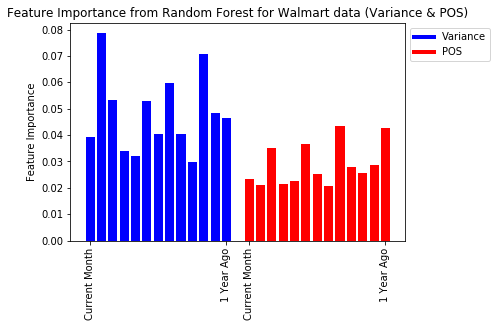

In [1171]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance'),
                   Line2D([0], [0], color='r', lw=4, label='POS')]
plt.bar(range(13), feature_importance[:13], color='b')# color=13*'b' + 13*'r')
plt.bar(range(14, 27), feature_importance[13:], color='r')
plt.xticks([0, 12, 14, 26], ['Current Month', '1 Year Ago', 'Current Month', '1 Year Ago'], rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance from Random Forest for W data (Variance & POS)')
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1,1))
# plt.savefig('RandomForest_featureimportance.png',format='png')

In [872]:
import eli5
from eli5.sklearn import PermutationImportance

In [874]:
# changes every time. Average over many runs
model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(100, max_depth=7))
    ])
model.fit(X_train, np.argmax(y_train,1))

perm = PermutationImportance(model, scoring='f1_macro').fit(X_test, np.argmax(y_test,1))
eli5.show_weights(perm)

Weight,Feature
0.0035 ± 0.0022,x12
0.0023 ± 0.0025,x7
0.0022 ± 0.0039,x4
0.0022 ± 0.0028,x17
0.0022 ± 0.0028,x11
0.0017 ± 0.0033,x8
0.0017 ± 0.0017,x20
0.0017 ± 0.0017,x3
0.0013 ± 0.0021,x9
0.0004 ± 0.0017,x18


In [789]:
import warnings
warnings.filterwarnings('ignore')

In [876]:
model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(100, max_depth=5))
    ])

permutation_importance(model, 100)

,features,weight,std
0,Var_Month11,0.00971467,0.0139996
1,Var_Month1,0.00892598,0.0176707
2,Var_Month10,0.00754931,0.012265
3,Var_Month4,0.00752341,0.0164246
4,Var_Month5,0.00740284,0.0103845
5,Var_Month0,0.00584065,0.0112652
6,POS_Month12,0.00575369,0.0127424
7,Var_Month7,0.00407329,0.0114445
8,POS_Month6,0.00387505,0.0114823
9,POS_Month11,0.00355644,0.0112176


## kNN

In [410]:
from sklearn.neighbors import KNeighborsClassifier

In [1042]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier())
])

# Grid search parameters
n_neighbors = list(range(1,6))

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__n_neighbors':n_neighbors}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))

In [1043]:
grid_search.best_params_

{'clf__n_neighbors': 1}

In [1044]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(1))
])

results = evaluate_model(model)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.144
precision_micro 0.534
recall_macro 0.152
recall_micro 0.534
f1_macro 0.148
f1_micro 0.534
gms_macro 0.358
gms_micro 0.696


In [877]:
model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', KNeighborsClassifier(1))
    ])


permutation_importance(model, 100)

,features,weight,std
0,POS_Month9,0.0559173,0.0223111
1,Var_Month0,0.0416923,0.0231575
2,Var_Month12,0.0401391,0.0139138
3,Var_Month8,0.0375735,0.0108627
4,Var_Month7,0.0358671,0.0124753
5,POS_Month11,0.0313403,0.0235877
6,Var_Month4,0.0305631,0.0159751
7,POS_Month7,0.0298791,0.0289659
8,Var_Month5,0.0283033,0.0116363
9,POS_Month1,0.0274725,0.0320924


## SVM

In [418]:
from sklearn.svm import SVC

In [1039]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC())
])

# Grid search parameters
Cs = [0.1, 1, 10, 20, 30, 40, 50]
gammas = [0.001, 0.01, 0.1, 1]

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__C':Cs, 'clf__gamma':gammas}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))

In [1040]:
grid_search.best_params_

{'clf__C': 10, 'clf__gamma': 0.1}

In [1041]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=10, gamma=0.1))
])

results = evaluate_model(model)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.172
precision_micro 0.455
recall_macro 0.13
recall_micro 0.455
f1_macro 0.14
f1_micro 0.455
gms_macro 0.327
gms_micro 0.637


## Gradient Boost

In [509]:
from sklearn.ensemble import GradientBoostingClassifier

In [1172]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier())
])

parameters = {
    "clf__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
    "clf__min_samples_split": np.linspace(0.1, 0.5, 12),
    "clf__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "clf__max_depth":[3,5,8]
    }

clf = GridSearchCV(model, parameters, scoring='f1_macro', cv=5, n_jobs=-1)
clf.fit(X_train, np.argmax(y_train,1))
clf.best_params_

{'clf__learning_rate': 0.025,
 'clf__max_depth': 3,
 'clf__min_samples_leaf': 0.1,
 'clf__min_samples_split': 0.2090909090909091}

In [1176]:
scores = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']

for score, param in zip(scores, params):
    if score > 0.26:
        print(score, param)

0.26557973604009283 {'clf__learning_rate': 0.01, 'clf__max_depth': 8, 'clf__min_samples_leaf': 0.1, 'clf__min_samples_split': 0.13636363636363638}
0.268280495896142 {'clf__learning_rate': 0.025, 'clf__max_depth': 3, 'clf__min_samples_leaf': 0.1, 'clf__min_samples_split': 0.2090909090909091}
0.26017976251387775 {'clf__learning_rate': 0.025, 'clf__max_depth': 8, 'clf__min_samples_leaf': 0.1, 'clf__min_samples_split': 0.13636363636363638}


In [1177]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.025, max_depth=3, 
                                       min_samples_leaf=0.1, min_samples_split=0.21))
])

results = evaluate_model(model)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.251
precision_micro 0.576
recall_macro 0.199
recall_micro 0.576
f1_macro 0.203
f1_micro 0.576
gms_macro 0.405
gms_micro 0.723


In [1168]:
feature_importance = np.zeros(26)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier(learning_rate=0.05, max_depth=8, 
                                       min_samples_leaf=0.125, min_samples_split=0.4))
    ])
    model.fit(X, np.argmax(y, 1))
    feature_importance += model.steps[1][1].feature_importances_
feature_importance /= 100

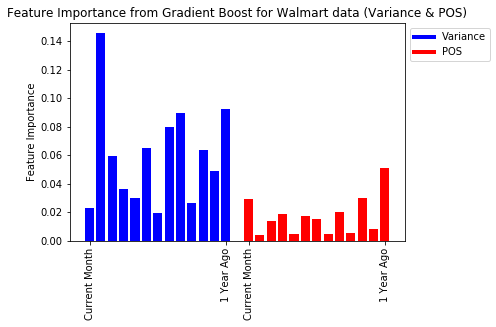

In [1169]:
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance'),
                   Line2D([0], [0], color='r', lw=4, label='POS')]
plt.bar(range(13), feature_importance[:13], color='b')# color=13*'b' + 13*'r')
plt.bar(range(14, 27), feature_importance[13:], color='r')
plt.xticks([0, 12, 14, 26], ['Current Month', '1 Year Ago', 'Current Month', '1 Year Ago'], rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance from Gradient Boost for W data (Variance & POS)')
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1,1))
# plt.savefig('Gboost_featureimportance.png', format='png')

In [913]:
# model = Pipeline([
#         ('sampling', RandomOverSampler()),
#         ('clf', GradientBoostingClassifier())
#     ])

model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.075, max_depth=3, 
                                       min_samples_leaf=0.136, min_samples_split=0.354))
])

permutation_importance(model, 100)

,features,weight,std
0,Var_Month12,0.0464147,0.0277581
1,Var_Month1,0.0410685,0.0344482
2,Var_Month11,0.0323608,0.0174149
3,Var_Month5,0.0302515,0.0228091
4,POS_Month8,0.0209804,0.0112281
5,Var_Month10,0.0123638,0.0114126
6,Var_Month3,0.0106563,0.0171911
7,POS_Month2,0.00973397,0.0106804
8,Var_Month7,0.00874709,0.0191093
9,POS_Month0,0.00827333,0.0112692


In [803]:
model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier())
    ])


model.fit(X_train, np.argmax(y_train,1))

perm = PermutationImportance(model, scoring='f1_macro').fit(X_test, np.argmax(y_test,1))
eli5.show_weights(perm, feature_names=['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)])

Weight,Feature
0.0008 ± 0.0020,POS_Month1
0.0007 ± 0.0027,Var_Month4
0.0001 ± 0.0022,Var_Month2
0 ± 0.0000,POS_Month8
0 ± 0.0000,POS_Month4
-0.0001 ± 0.0014,Var_Month11
-0.0003 ± 0.0034,Var_Month5
-0.0008 ± 0.0020,POS_Month10
-0.0009 ± 0.0052,Var_Month0
-0.0014 ± 0.0000,POS_Month2


In [799]:
model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier(learning_rate=0.075, max_depth=8, 
                                       min_samples_leaf=0.125, min_samples_split=0.4))
    ])
model.fit(X_train, np.argmax(y_train,1))

explainer = shap.KernelExplainer(model.predict_proba, X_train)
shap_values = explainer.shap_values(X_test[0])
shap.force_plot(explainer.expected_value[0], shap_values[0], 
                ['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)])

Using 228 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [1283]:
single_shap_values = explainer.shap_values(X_inv_test[0])
shap.force_plot(explainer.expected_value[0], single_shap_values[0], 
                ['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)])

Exception: Length of features is not equal to the length of shap_values!

In [1281]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], 
                ['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)])

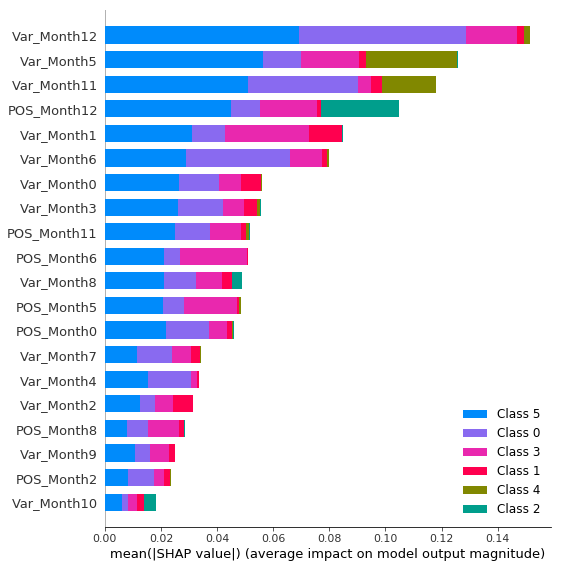

In [808]:
shap.summary_plot(shap_values, ['Var_Month'+ str(i) for i in range(0,13)] + ['POS_Month'+ str(i) for i in range(13)])

In [805]:
label_cols

['Promo', 'Phasing', 'SP&D', 'POS', 'Other', 'NoComm']

# Including Inventory

In [1538]:
X_inv = np.concatenate((BR_TR_timeseries_windows, monthly_pos_windows, monthly_inv_windows), axis=1)
X_inv_train, X_inv_test, y_inv_train, y_inv_test = train_test_split(X_inv, y, test_size=0.2, random_state=0)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [1025]:
def evaluate_model3(estimator, xtrain, xtest, ytrain, ytest, runs=10):
    
    metrics = ['precision_macro', 'precision_micro', 'recall_macro', 'recall_micro',
              'f1_macro', 'f1_micro', 'gms_macro', 'gms_micro']
    results = {m:[] for m in metrics}

    for _ in range(runs):
        model = estimator
        model.fit(xtrain, np.argmax(ytrain, 1))
        y_pred = model.predict(xtest)

        results['precision_macro'].append(precision_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['precision_micro'].append(precision_score(np.argmax(ytest,1), y_pred, average='micro')) 
        results['recall_macro'].append(recall_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['recall_micro'].append(recall_score(np.argmax(ytest,1), y_pred, average='micro'))
        results['f1_macro'].append(f1_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['f1_micro'].append(f1_score(np.argmax(ytest,1), y_pred, average='micro'))
        results['gms_macro'].append(geometric_mean_score(np.argmax(ytest,1), y_pred, average='macro'))
        results['gms_micro'].append(geometric_mean_score(np.argmax(ytest,1), y_pred, average='micro'))
    
    return results

In [1290]:
def permutation_importance3(estimator, xtrain, xtest, ytrain, ytest, runs=10):
    m = xtrain.shape[1]
    weights = np.zeros(m)
    std = np.zeros(m)
    for _ in range(runs):
        model = estimator
        model.fit(xtrain, np.argmax(ytrain,1))

        perm = PermutationImportance(model, scoring='f1_macro').fit(xtest, np.argmax(ytest, 1))
        df = eli5.format_as_dataframe(eli5.explain_weights(perm, top=m, feature_names=[str(i) for i in range(m)]))
        df['feature'] = pd.to_numeric(df['feature'])
        df.sort_values(by='feature', inplace=True)
        
        weights += df['weight'].values
        std += df['std'].values
        
    weights /= runs
    std /= runs
    features = ['Var_Month'+ str(i) for i in range(13)] +\
               ['POS_Month'+ str(i) for i in range(13)] +\
               ['Inv_Month'+ str(i) for i in range(13)]

    df_perm_importance = pd.DataFrame(data=np.vstack((weights, std)).T, columns=['weight', 'std'])
    df_perm_importance.insert(0, 'features', features)
    df_perm_importance.sort_values('weight', ascending=False, inplace=True)
    df_perm_importance.reset_index(drop=True, inplace=True)
    
    return df_perm_importance.style.apply(color_dataframe, axis=1)
    

## kNN with inv

In [1077]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier())
])

# Grid search parameters
n_neighbors = list(range(1,6))

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__n_neighbors':n_neighbors}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_inv_train, np.argmax(y_inv_train, axis=1))

In [1078]:
grid_search.best_params_

{'clf__n_neighbors': 2}

In [1079]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(2))
])


results = evaluate_model3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.21
precision_micro 0.483
recall_macro 0.218
recall_micro 0.483
f1_macro 0.214
f1_micro 0.483
gms_macro 0.425
gms_micro 0.658


In [1081]:
model.predict(X_inv_test)

array([5, 5, 5, 5, 3, 5, 5, 0, 5, 5, 5, 5, 3, 5, 5, 5, 0, 5, 5, 2, 5, 0,
       5, 0, 5, 1, 5, 5, 2, 5, 0, 5, 0, 0, 5, 0, 5, 5, 5, 0, 5, 5, 1, 5,
       5, 5, 5, 2, 5, 5, 5, 3, 5, 5, 5, 5, 5, 4])

In [1084]:
np.argmax(y_inv_test, 1)

array([5, 5, 5, 5, 5, 1, 0, 5, 5, 5, 0, 5, 5, 5, 0, 0, 3, 5, 5, 5, 4, 3,
       5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 0, 3, 5, 3, 5, 5, 5, 1, 5,
       3, 3, 5, 3, 5, 5, 5, 5, 0, 5, 5, 3, 0, 5])

In [1298]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.075, max_depth=5, 
                                       min_samples_leaf=0.173, min_samples_split=0.354))
])

permutation_importance3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test)

,features,weight,std
0,Var_Month1,0.0455524,0.0190094
1,Var_Month5,0.0365689,0.0188851
2,Var_Month4,0.0338396,0.0122118
3,Var_Month8,0.0275377,0.0193401
4,Inv_Month8,0.026126,0.0148767
5,Inv_Month5,0.0252346,0.0194358
6,Var_Month12,0.0127993,0.0189947
7,Var_Month3,0.0104356,0.0124048
8,POS_Month0,0.00877683,0.00647113
9,Var_Month7,0.00873245,0.021473


## SVM with inv

In [1091]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC())
])

# Grid search parameters
Cs = [0.1, 1, 10, 20, 30, 40, 50]
gammas = [0.001, 0.01, 0.1, 1]

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__C':Cs, 'clf__gamma':gammas}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_inv_train, np.argmax(y_inv_train, axis=1))

In [1092]:
grid_search.best_params_

{'clf__C': 1, 'clf__gamma': 0.1}

In [1094]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=1, gamma=0.1))
])

results = evaluate_model3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.17
precision_micro 0.467
recall_macro 0.134
recall_micro 0.467
f1_macro 0.143
f1_micro 0.467
gms_macro 0.333
gms_micro 0.645


## Random Forest with inv

In [1065]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier())
])

# Grid search parameters
n_estimators = [10, 50, 100, 150, 200]
max_depth = [3, 5, 7, 9, 11, 13, 15, None]

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__n_estimators':n_estimators, 'clf__max_depth':max_depth}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_inv_train, np.argmax(y_inv_train, axis=1))

In [1066]:
grid_search.best_params_

{'clf__max_depth': 5, 'clf__n_estimators': 100}

In [1067]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier(100, max_depth=5))
])

results = evaluate_model3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.315
precision_micro 0.626
recall_macro 0.236
recall_micro 0.626
f1_macro 0.229
f1_micro 0.626
gms_macro 0.436
gms_micro 0.753


In [1269]:
feature_importance = np.zeros(39)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(100, max_depth=5))
    ])
    model.fit(X_inv, np.argmax(y, 1))
    feature_importance += model.steps[1][1].feature_importances_
feature_importance /= 100    

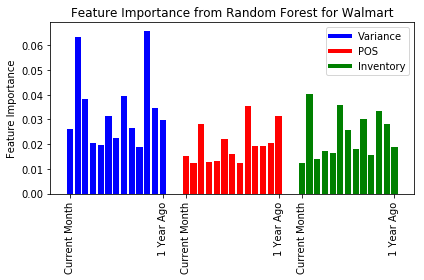

In [1274]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance'),
                   Line2D([0], [0], color='r', lw=4, label='POS'),
                   Line2D([0], [0], color='g', lw=4, label='Inventory')]
plt.bar(range(13), feature_importance[:13], color='b')
plt.bar(range(15, 28), feature_importance[13:26], color='r')
plt.bar(range(30, 43), feature_importance[26:], color='g')
plt.xticks([0, 12, 15, 27, 30, 42], 
           ['Current Month', '1 Year Ago', 
            'Current Month', '1 Year Ago', 
            'Current Month', '1 Year Ago'], rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance from Random Forest for W')
plt.legend(handles=legend_elements, loc="best")
plt.tight_layout()
plt.savefig('RandomForest_featureimportance.png',format='png')

## Gradient Boost with inv

In [1070]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier())
])

parameters = {
    "clf__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "clf__min_samples_split": np.linspace(0.1, 0.5, 12),
    "clf__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "clf__max_depth":[3,5,8, None]
    }

clf = GridSearchCV(model, parameters, scoring='f1_macro', cv=5, n_jobs=-1)
clf.fit(X_inv_train, np.argmax(y_inv_train,1))
clf.best_params_

{'clf__learning_rate': 0.075,
 'clf__max_depth': 5,
 'clf__min_samples_leaf': 0.17272727272727273,
 'clf__min_samples_split': 0.3545454545454546}

In [1071]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.075, max_depth=5, 
                                       min_samples_leaf=0.173, min_samples_split=0.354))
])

results = evaluate_model3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.264
precision_micro 0.631
recall_macro 0.215
recall_micro 0.631
f1_macro 0.21
f1_micro 0.631
gms_macro 0.417
gms_micro 0.757


In [1275]:
feature_importance = np.zeros(39)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier(learning_rate=0.075, max_depth=5, 
                                       min_samples_leaf=0.173, min_samples_split=0.354))
    ])
    model.fit(X_inv, np.argmax(y, 1))
    feature_importance += model.steps[1][1].feature_importances_
feature_importance /= 100

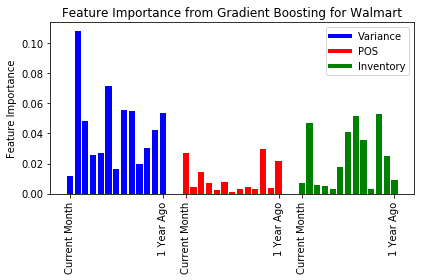

In [1277]:
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance'),
                   Line2D([0], [0], color='r', lw=4, label='POS'),
                   Line2D([0], [0], color='g', lw=4, label='Inventory')]
plt.bar(range(13), feature_importance[:13], color='b')
plt.bar(range(15, 28), feature_importance[13:26], color='r')
plt.bar(range(30, 43), feature_importance[26:], color='g')
plt.xticks([0, 12, 15, 27, 30, 42], 
           ['Current Month', '1 Year Ago', 
            'Current Month', '1 Year Ago', 
            'Current Month', '1 Year Ago'], rotation=90)

plt.ylabel('Feature Importance')
plt.title('Feature Importance from Gradient Boosting for W')
plt.legend(handles=legend_elements, loc="best")
plt.tight_layout()
plt.savefig('Gboost_featureimportance.png', format='png')

## LSTM with inv

In [1110]:
from utils import SplitAndReshape3

In [1100]:
def create_model3(h1=100, h2=60, h3=60, dropout=0.2, recurrent_dropout=0.2):
    var_input = Input(shape=(WINDOW_SIZE, 1))
    var_lstm = LSTM(h1, dropout=dropout, recurrent_dropout=recurrent_dropout)
    var_output = var_lstm(var_input)

    pos_input = Input(shape=(WINDOW_SIZE, 1))
    pos_lstm = LSTM(h2, dropout=dropout, recurrent_dropout=recurrent_dropout)
    pos_output = pos_lstm(pos_input)
    
    inv_input = Input(shape=(WINDOW_SIZE, 1))
    inv_lstm = LSTM(h3, dropout=dropout, recurrent_dropout=recurrent_dropout)
    inv_output = inv_lstm(inv_input)

    merged = concatenate([var_output, pos_output, inv_output])
    classifier = Dense(6, activation='softmax')
    model_output = classifier(merged)

    model = Model([var_input, pos_input, inv_input], model_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    
    return model

In [1112]:
model = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', utils.SplitAndReshape3()),
    ('clf', KerasClassifier(create_model3, epochs=60, batch_size=16, verbose=0))
])

results = evaluate_model3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test, runs=5)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.193
precision_micro 0.531
recall_macro 0.205
recall_micro 0.531
f1_macro 0.192
f1_micro 0.531
gms_macro 0.409
gms_micro 0.692


## SHAP

In [1326]:
shap.kmeans()

(50, 39)

## LSTM SHAP

In [1387]:
# model = Pipeline([
#         ('sampling', RandomOverSampler()),
#         ('clf', RandomForestClassifier(100, max_depth=5))
#     ])

model = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', utils.SplitAndReshape3()),
    ('clf', KerasClassifier(create_model3, epochs=60, batch_size=16, verbose=0))
])


model.fit(X_inv_train, np.argmax(y_inv_train,1))

Pipeline(memory=None,
     steps=[('sampling', RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('reshape', <utils.SplitAndReshape3 object at 0x7fabca59aa90>), ('clf', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fabca5e0e80>)])

In [ ]:
X_summary = shap.kmeans(X_inv_train, 50)
explainer = shap.KernelExplainer(model.predict_proba, X_summary)
shap_values = explainer.shap_values(X_inv_test)


 95%|█████████▍| 55/58 [36:20<01:58, 39.58s/it]

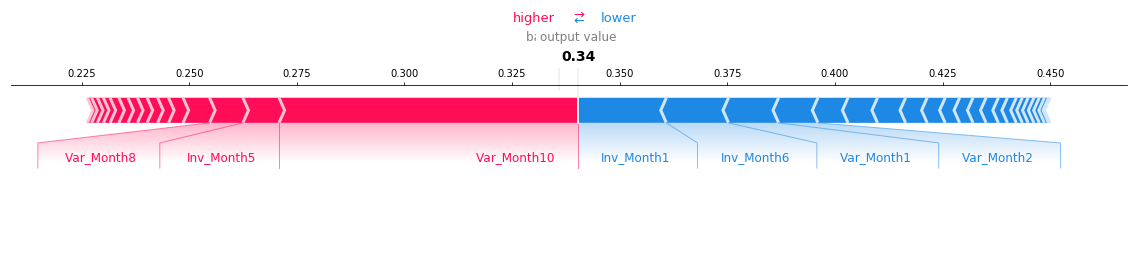

In [1370]:
# single_shap_values = explainer.shap_values(X_inv_test[0])
shap.force_plot(explainer.expected_value[5], single_shap_values[5], feature_names, matplotlib=True)


In [ ]:
mean_shap_values = np.mean(np.abs(shap_values), axis=1)

In [ ]:
shap_df = pd.DataFrame(mean_shap_values.T, columns=label_cols, index=feature_names)
shap_df.head()

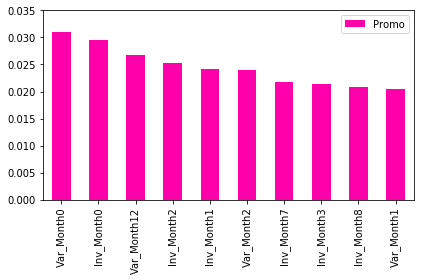

In [1392]:
# shap_df.sort_values('Promo', ascending=False, inplace=True)
shap_df.sort_values('Promo', ascending=False)[:10].plot(kind='bar', y='Promo', ylim=(0,0.035), color='#FF00AA')
plt.tight_layout()
# plt.savefig('RFPromo.png', format='png')

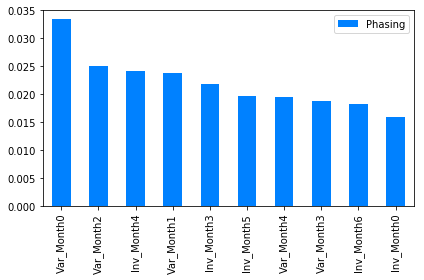

In [1393]:
shap_df.sort_values('Phasing', ascending=False)[:10].plot(kind='bar', y='Phasing', color='#0081FF', ylim=(0,0.035))
plt.tight_layout()
# plt.savefig('RFPhasing.png', format='png')

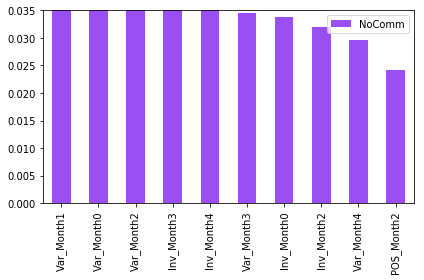

In [1394]:
shap_df.sort_values('NoComm', ascending=False)[:10].plot(kind='bar', y='NoComm', color='#994FF2', ylim=(0,0.035))
plt.tight_layout()
# plt.savefig('RFNoComm.png', format='png')

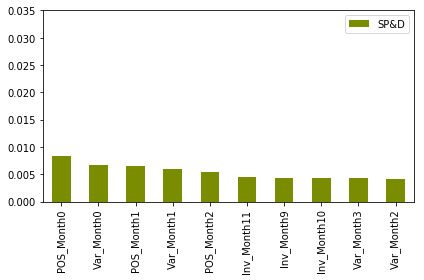

In [1395]:
shap_df.sort_values('SP&D', ascending=False)[:10].plot(kind='bar', y='SP&D', color='#7A8C00', ylim=(0,0.035))
plt.tight_layout()
# plt.savefig('RF_SPnD.png', format='png')

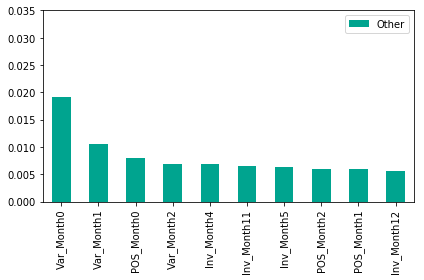

In [1396]:
shap_df.sort_values('Other', ascending=False)[:10].plot(kind='bar', y='Other', color='#00A48F', ylim=(0,0.035))
plt.tight_layout()
# plt.savefig('RFOther.png', format='png')

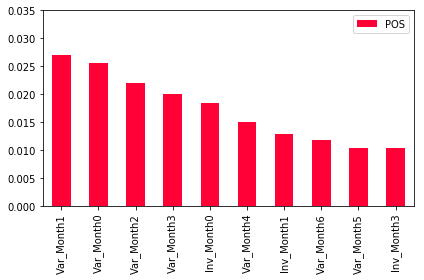

In [1397]:
shap_df.sort_values('POS', ascending=False)[:10].plot(kind='bar', y='POS', color='#FF0037', ylim=(0,0.035))
plt.tight_layout()
# plt.savefig('RF_POS.png', format='png')

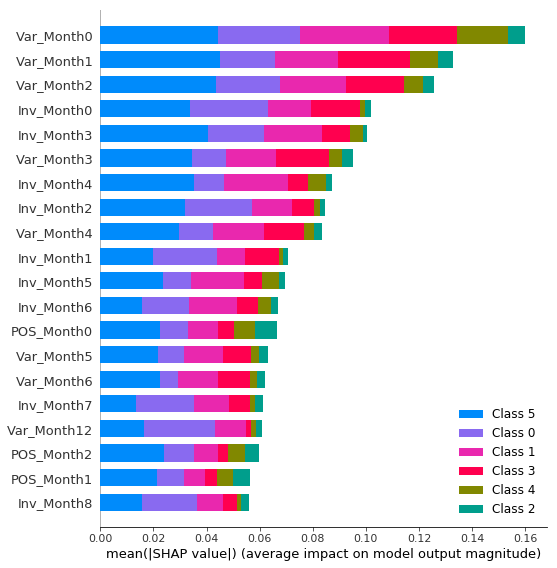

In [1398]:
feature_names = ['Var_Month'+ str(i) for i in range(13)] +\
                ['POS_Month'+ str(i) for i in range(13)] +\
                ['Inv_Month'+ str(i) for i in range(13)]
shap.summary_plot(shap_values, feature_names=feature_names, max_display=20)
# plt.savefig('RF_Summary.png', format='png')

## Random Forest SHAP

In [1399]:
model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(100, max_depth=5))
    ])

model.fit(X_inv, np.argmax(y,1))

Pipeline(memory=None,
     steps=[('sampling', RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impur...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [1400]:
explainer = shap.KernelExplainer(model.predict_proba, X_inv)
shap_values = explainer.shap_values(X_inv)

Using 286 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.

100%|██████████| 286/286 [40:01<00:00,  8.47s/it]

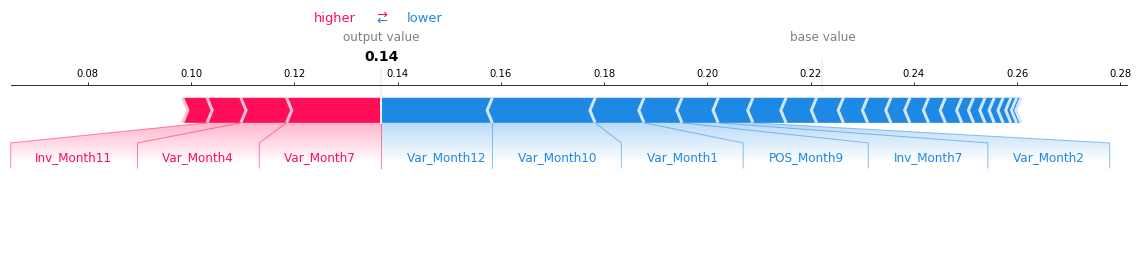

In [1401]:
# single_shap_values = explainer.shap_values(X_inv_test[0])
shap.force_plot(explainer.expected_value[0], single_shap_values[0], feature_names, matplotlib=True)


In [1402]:
mean_shap_values = np.mean(np.abs(shap_values), axis=1)

In [1403]:
shap_df = pd.DataFrame(mean_shap_values.T, columns=label_cols, index=feature_names)
shap_df.head()

,Promo,Phasing,SP&D,POS,Other,NoComm
Var_Month0,0.002583,0.001229,0.002114,0.002197,0.004355,0.001794
Var_Month1,0.006693,0.028867,0.011766,0.024367,0.005252,0.007374
Var_Month2,0.003687,0.001557,0.008108,0.005227,0.002393,0.003513
Var_Month3,0.002101,0.002384,0.000353,0.002952,0.002157,0.002381
Var_Month4,0.002216,0.002451,0.001624,0.001827,0.002266,0.004610


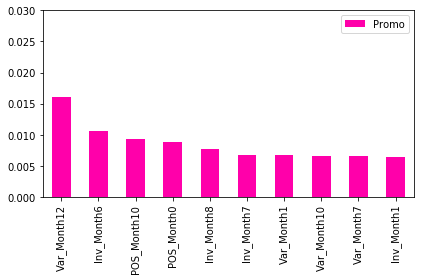

In [1406]:
# shap_df.sort_values('Promo', ascending=False, inplace=True)
shap_df.sort_values('Promo', ascending=False)[:10].plot(kind='bar', y='Promo', ylim=(0,0.03), color='#FF00AA')
plt.tight_layout()
# plt.savefig('RFPromo.png', format='png')

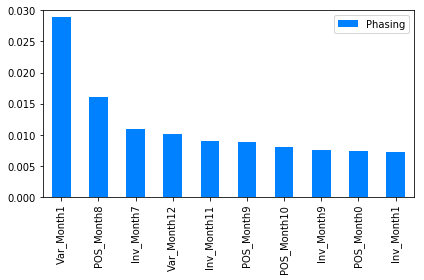

In [1407]:
shap_df.sort_values('Phasing', ascending=False)[:10].plot(kind='bar', y='Phasing', color='#0081FF', ylim=(0,0.03))
plt.tight_layout()
# plt.savefig('RFPhasing.png', format='png')

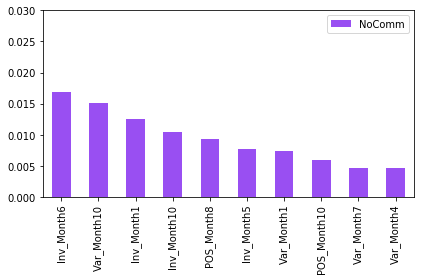

In [1408]:
shap_df.sort_values('NoComm', ascending=False)[:10].plot(kind='bar', y='NoComm', color='#994FF2', ylim=(0,0.03))
plt.tight_layout()
# plt.savefig('RFNoComm.png', format='png')

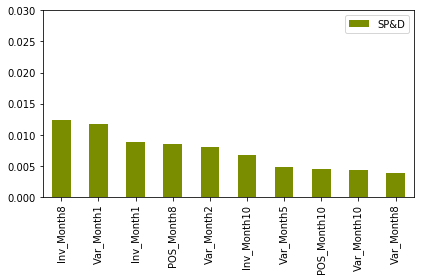

In [1409]:
shap_df.sort_values('SP&D', ascending=False)[:10].plot(kind='bar', y='SP&D', color='#7A8C00', ylim=(0,0.03))
plt.tight_layout()
# plt.savefig('RF_SPnD.png', format='png')

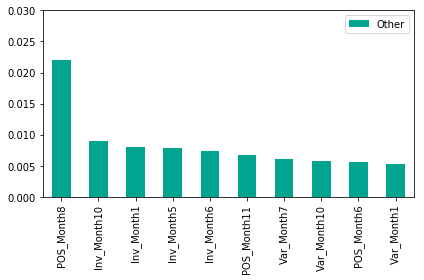

In [1410]:
shap_df.sort_values('Other', ascending=False)[:10].plot(kind='bar', y='Other', color='#00A48F', ylim=(0,0.03))
plt.tight_layout()
# plt.savefig('RFOther.png', format='png')

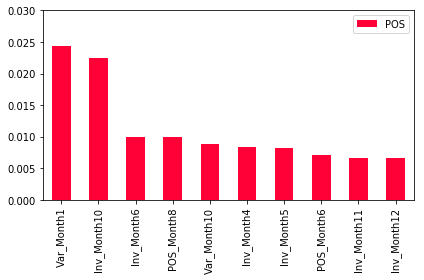

In [1411]:
shap_df.sort_values('POS', ascending=False)[:10].plot(kind='bar', y='POS', color='#FF0037', ylim=(0,0.03))
plt.tight_layout()
# plt.savefig('RF_POS.png', format='png')

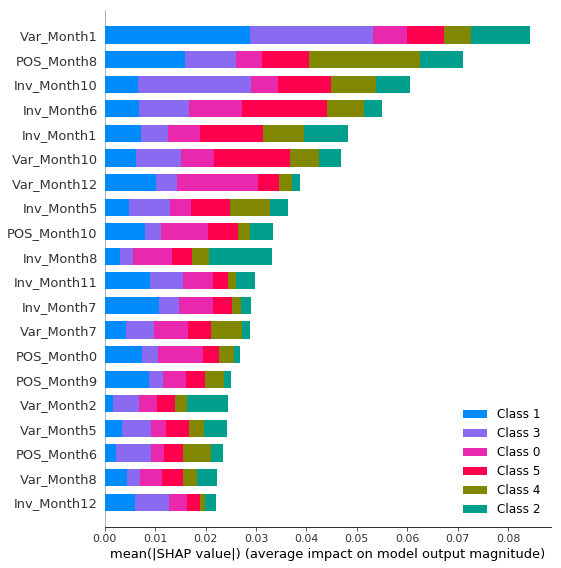

In [1412]:
feature_names = ['Var_Month'+ str(i) for i in range(13)] +\
                ['POS_Month'+ str(i) for i in range(13)] +\
                ['Inv_Month'+ str(i) for i in range(13)]
shap.summary_plot(shap_values, feature_names=feature_names, max_display=20)
# plt.savefig('RF_Summary.png', format='png')

In [1234]:
label_cols

['Promo', 'Phasing', 'SP&D', 'POS', 'Other', 'NoComm']

# Only Variance (W)

In [1113]:
X_var = BR_TR_timeseries_windows[:]
X_var_train, X_var_test, y_var_train, y_var_test = train_test_split(X_var, y, test_size=0.2, random_state=0)

## kNN with var

In [1116]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier())
])

# Grid search parameters
n_neighbors = list(range(1,6))

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__n_neighbors':n_neighbors}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_var_train, np.argmax(y_var_train, axis=1))

In [1117]:
grid_search.best_params_

{'clf__n_neighbors': 1}

In [1154]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(1))
])


results = evaluate_model3(model, X_var_train, X_var_test, y_var_train, y_var_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.497
precision_micro 0.672
recall_macro 0.335
recall_micro 0.672
f1_macro 0.34
f1_micro 0.672
gms_macro 0.531
gms_micro 0.786


In [1360]:
from sklearn.dummy import DummyClassifier


In [1365]:
model = Pipeline([
    ('clf', DummyClassifier(strategy='most_frequent'))
])


results = evaluate_model3(model, X_inv_train, X_inv_test, y_inv_train, y_inv_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.134
precision_micro 0.672
recall_macro 0.2
recall_micro 0.672
f1_macro 0.161
f1_micro 0.672
gms_macro 0.4
gms_micro 0.786


In [1366]:
model.predict(X_var_test)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [1122]:
model.predict(X_var_test)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 3,
       5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 1, 5,
       5, 5, 5, 0, 5, 1, 5, 5, 0, 5, 5, 5, 5, 4])

In [1121]:
np.argmax(y_var_test, 1)

array([5, 5, 5, 5, 5, 1, 0, 5, 5, 5, 0, 5, 5, 5, 0, 0, 3, 5, 5, 5, 4, 3,
       5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 0, 3, 5, 3, 5, 5, 5, 1, 5,
       3, 3, 5, 3, 5, 5, 5, 5, 0, 5, 5, 3, 0, 5])

## SVM with var

In [1125]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC())
])

# Grid search parameters
Cs = [0.1, 1, 10, 20, 30, 40, 50]
gammas = [0.001, 0.01, 0.1, 1]

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__C':Cs, 'clf__gamma':gammas}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_var_train, np.argmax(y_var_train, axis=1))

In [1126]:
grid_search.best_params_

{'clf__C': 10, 'clf__gamma': 1}

In [1128]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=10, gamma=1))
])

results = evaluate_model3(model, X_var_train, X_var_test, y_var_train, y_var_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.202
precision_micro 0.581
recall_macro 0.17
recall_micro 0.581
f1_macro 0.167
f1_micro 0.581
gms_macro 0.375
gms_micro 0.728


## Random Forest with var

In [1133]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier())
])

# Grid search parameters
n_estimators = [10, 50, 100, 150, 200]
max_depth = [3, 5, 7, 9, 11, 13, 15, None]

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__n_estimators':n_estimators, 'clf__max_depth':max_depth}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_var_train, np.argmax(y_var_train, axis=1))

In [1134]:
grid_search.best_params_

{'clf__max_depth': 5, 'clf__n_estimators': 200}

In [1135]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier(200, max_depth=5))
])

results = evaluate_model3(model, X_var_train, X_var_test, y_var_train, y_var_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.209
precision_micro 0.655
recall_macro 0.212
recall_micro 0.655
f1_macro 0.197
f1_micro 0.655
gms_macro 0.418
gms_micro 0.775


In [1155]:
feature_importance = np.zeros(13)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', RandomForestClassifier(200, max_depth=5))
    ])
    model.fit(X_var, np.argmax(y, 1))
    feature_importance += model.steps[1][1].feature_importances_
feature_importance /= 100    

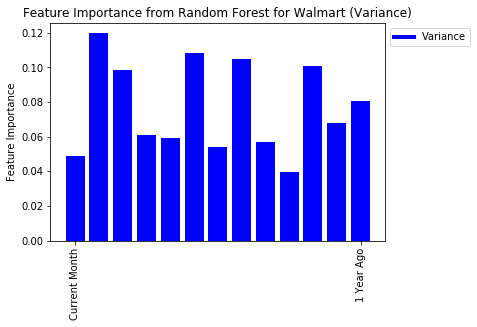

In [1156]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance')]
plt.bar(range(13), feature_importance[:13], color='b')
plt.xticks([0, 12], 
           ['Current Month', '1 Year Ago'], rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance from Random Forest for W (Variance)')
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1,1))
# plt.savefig('RandomForest_featureimportance.png',format='png')

## Gradient Boost with var

In [1139]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier())
])

parameters = {
    "clf__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "clf__min_samples_split": np.linspace(0.1, 0.5, 12),
    "clf__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "clf__max_depth":[3,5,8, None]
    }

clf = GridSearchCV(model, parameters, scoring='f1_macro', cv=5, n_jobs=-1)
clf.fit(X_var_train, np.argmax(y_var_train,1))
clf.best_params_

{'clf__learning_rate': 0.025,
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 0.1,
 'clf__min_samples_split': 0.13636363636363638}

In [1140]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier(learning_rate=0.025, max_depth=8, 
                                       min_samples_leaf=0.1, min_samples_split=0.136))
])

results = evaluate_model3(model, X_var_train, X_var_test, y_var_train, y_var_test, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.221
precision_micro 0.553
recall_macro 0.186
recall_micro 0.553
f1_macro 0.191
f1_micro 0.553
gms_macro 0.392
gms_micro 0.706


In [1157]:
feature_importance = np.zeros(13)
for _ in range(100):
    model = Pipeline([
        ('sampling', RandomOverSampler()),
        ('clf', GradientBoostingClassifier(learning_rate=0.025, max_depth=8, 
                                       min_samples_leaf=0.1, min_samples_split=0.136))
    ])
    model.fit(X_var, np.argmax(y, 1))
    feature_importance += model.steps[1][1].feature_importances_
feature_importance /= 100

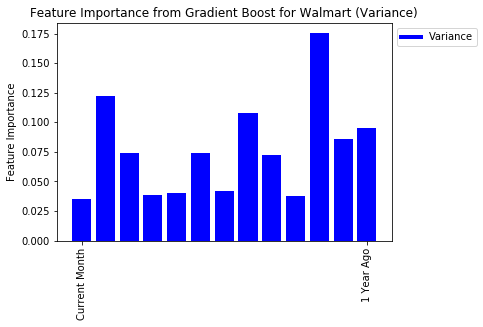

In [1158]:
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Variance')]
plt.bar(range(13), feature_importance[:13], color='b')
plt.xticks([0, 12], 
           ['Current Month', '1 Year Ago'], rotation=90)

plt.ylabel('Feature Importance')
plt.title('Feature Importance from Gradient Boost for W (Variance)')
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1,1))
# plt.savefig('Gboost_featureimportance.png', format='png')

## LSTM with var

In [1110]:
from utils import SplitAndReshape3

In [1145]:
def create_model1(h1=100, dropout=0.2, recurrent_dropout=0.2):
    var_input = Input(shape=(WINDOW_SIZE, 1))
    var_lstm = LSTM(h1, dropout=dropout, recurrent_dropout=recurrent_dropout)
    var_output = var_lstm(var_input)

    classifier = Dense(6, activation='softmax')
    model_output = classifier(var_output)

    model = Model(var_input, model_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    
    return model

In [1147]:
model = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', Reshape()),
    ('clf', KerasClassifier(create_model1, epochs=60, batch_size=16, verbose=0))
])

results = evaluate_model3(model, X_var_train, X_var_test, y_var_train, y_var_test, runs=5)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.21
precision_micro 0.445
recall_macro 0.215
recall_micro 0.445
f1_macro 0.203
f1_micro 0.445
gms_macro 0.425
gms_micro 0.628


## tslearn

In [1424]:
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from keras.optimizers import Adagrad

In [1461]:
ros = RandomOverSampler()
X_temp, y_ts_train = ros.fit_resample(X_inv_train, y_inv_train)

X_ts_train = X_temp.reshape(X_temp.shape[0], 13,  3, order='F')
X_ts_test = X_inv_test.reshape(X_inv_test.shape[0], 13,  3, order='F')

In [1462]:
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_temp.shape[0],
                                                       ts_sz=X_ts_train.shape[1],
                                                       n_classes=6,
                                                       l=0.3,
                                                       r=2)

In [1464]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer=Adagrad(lr=.1),
                        weight_regularizer=.01,
                        max_iter=50,
                        verbose_level=0)
shp_clf.fit(X_ts_train, np.argmax(y_ts_train,1))

ShapeletModel(batch_size=256, max_iter=50, n_shapelets_per_size={3: 4, 6: 4},
       optimizer=<keras.optimizers.Adagrad object at 0x7faae613f6a0>,
       random_state=None, verbose_level=0, weight_regularizer=0.01)

In [1459]:
## No random sampling
f1_score(shp_clf.predict(X_ts_test), np.argmax(y_inv_test,1), average='macro')

0.16082474226804122

In [1468]:
## random sampling
f1_score(shp_clf.predict(X_ts_test), np.argmax(y_inv_test,1), average='macro')

0.0988095238095238

In [1487]:
X_test.shape

(58, 26)

In [ ]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier


knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")
knn_clf.fit(X_ts_train, np.argmax(y_ts_train, 1))
predicted_labels = knn_clf.predict(X_test)
# f1_score(predicted_labels, y_test, average='macro')

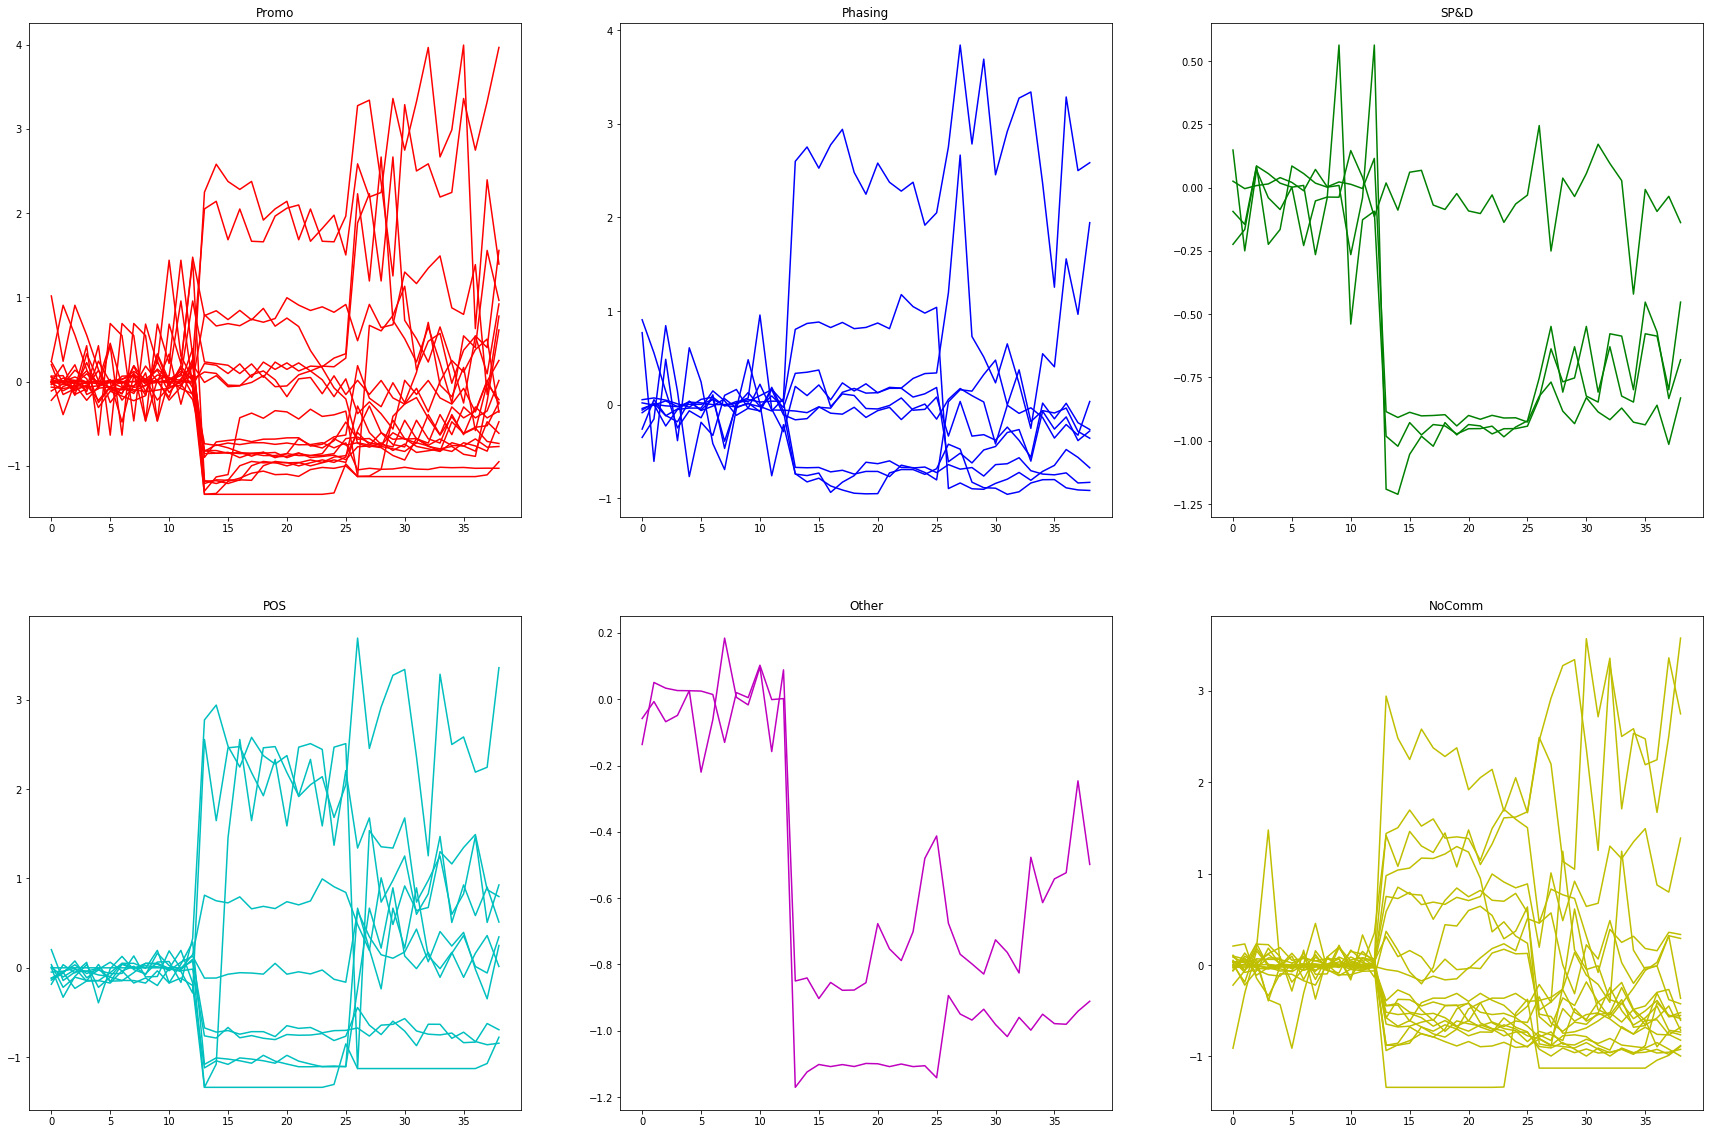

In [1533]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30,20))
colors = ['r','b','g','c', 'm', 'y']
for i in range(6):
    to_plot = X_inv_train[y_train[:, i]==1]
    for j in range(min(len(to_plot), 20)):
        ax.ravel()[i].plot(to_plot[j], c=colors[i])
        ax.ravel()[i].title.set_text(label_cols[i])
